# **Synthetic Cybersecurity Dataset Generator with Statistical Methods - Bayesian Networks**

In [1]:
!pip install pgmpy==0.1.20 --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Fix for numpy.product if needed (older bug workaround)
if not hasattr(np, 'product'):
    def product(*args, **kwargs):
        return np.prod(*args, **kwargs)
    np.product = product


## Data Loading and Exploration


**Dataset**: UCI Adult Income Dataset
Source: https://archive.ics.uci.edu/ml/datasets/adult

**Citation**: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository.

The notebook starts by loading the **UCI Adult Income Dataset**.

This dataset contains demographic information and income levels, making it suitable for cybersecurity scenarios where demographic data might be relevant for access control or anomaly detection.

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]
df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


In [5]:
disc_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df[disc_cols] = kb.fit_transform(df[disc_cols])

# Convert all to string (pgmpy requires categorical)
df = df.astype(str)
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,2.0,State-gov,0.0,Bachelors,3.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,0.0,2.0,United-States,<=50K
1,4.0,Self-emp-not-inc,0.0,Bachelors,3.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,0.0,United-States,<=50K
2,2.0,Private,3.0,HS-grad,1.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,2.0,United-States,<=50K
3,4.0,Private,3.0,11th,0.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,2.0,United-States,<=50K
4,1.0,Private,4.0,Bachelors,3.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,2.0,Cuba,<=50K


Using the Hill Climb Search algorithm with the BIC (Bayesian Information Criterion) scoring method to learn the optimal structure of the Bayesian Network from the dataset. The resulting directed acyclic graph (DAG) represents the conditional dependencies between variables, which we use to construct the Bayesian Network model.


In [6]:
hc = HillClimbSearch(df)
best_model = hc.estimate(scoring_method=BicScore(df))
model = BayesianNetwork(best_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

Fitting the parameters of the Bayesian Network using the BayesianEstimator with a BDeu prior. This estimates the conditional probability distributions for each node given its parents using the data in the DataFrame.


In [7]:
model.fit(df, estimator=BayesianEstimator, prior_type="BDeu")
print("Learned Bayesian Network structure:")
print(model.edges())


Learned Bayesian Network structure:
[('age', 'income'), ('age', 'occupation'), ('income', 'occupation'), ('income', 'hours-per-week'), ('occupation', 'workclass'), ('occupation', 'education'), ('occupation', 'hours-per-week'), ('education', 'education-num'), ('marital-status', 'relationship'), ('marital-status', 'age'), ('marital-status', 'sex'), ('relationship', 'sex'), ('relationship', 'income'), ('relationship', 'age'), ('relationship', 'race'), ('sex', 'occupation'), ('sex', 'hours-per-week'), ('race', 'native-country'), ('race', 'fnlwgt')]


Using `BayesianModelSampling` to generate synthetic data by sampling from the learned Bayesian Network. The `forward_sample` method simulates data based on the conditional dependencies in the model, producing a dataset of the same size as the original.


In [8]:
sampler = BayesianModelSampling(model)

synthetic_df = sampler.forward_sample(size=len(df), seed=42)

synthetic_df.head()

  0%|          | 0/13 [00:00<?, ?it/s]

,age,income,occupation,education,education-num,marital-status,relationship,sex,workclass,hours-per-week,race,native-country,fnlwgt
0,2.0,>50K,Exec-managerial,Some-college,2.0,Married-civ-spouse,Husband,Male,Local-gov,3.0,White,United-States,3.0
1,4.0,<=50K,Sales,Some-college,2.0,Separated,Not-in-family,Male,Private,3.0,White,United-States,3.0
2,0.0,<=50K,Exec-managerial,Some-college,2.0,Never-married,Unmarried,Female,Private,2.0,White,United-States,0.0
3,1.0,<=50K,Craft-repair,HS-grad,1.0,Married-spouse-absent,Unmarried,Female,Private,2.0,White,United-States,4.0
4,1.0,<=50K,Craft-repair,Some-college,2.0,Married-civ-spouse,Husband,Male,Private,2.0,White,United-States,4.0


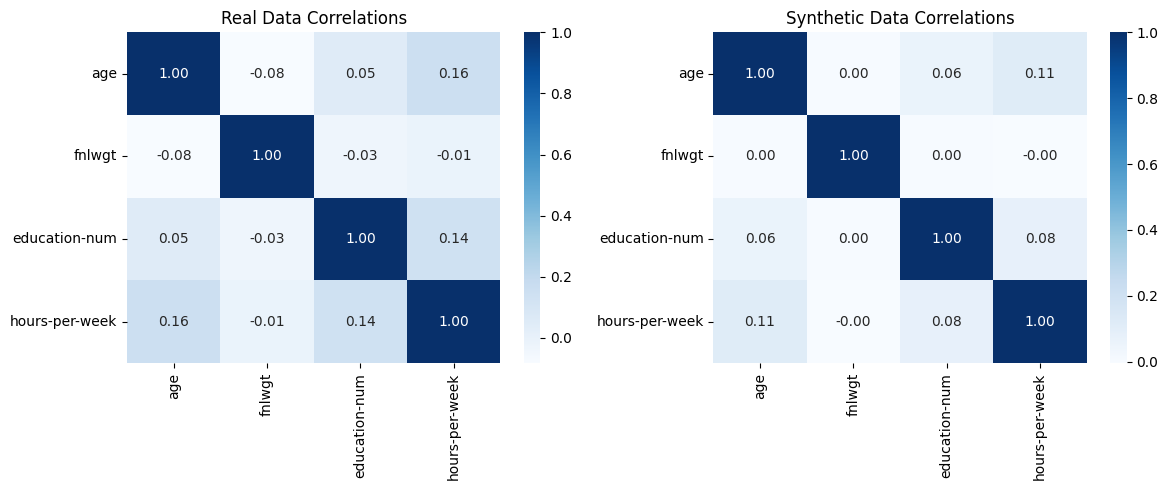

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

common_cols = [col for col in disc_cols if col in df.columns and col in synthetic_df.columns]

numeric_df = df[common_cols].astype(float)
numeric_synthetic_df = synthetic_df[common_cols].astype(float)

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(numeric_df.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Real Data Correlations")

plt.subplot(1, 2, 2)
sns.heatmap(numeric_synthetic_df.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Synthetic Data Correlations")

plt.tight_layout()
plt.show()


### Distribution

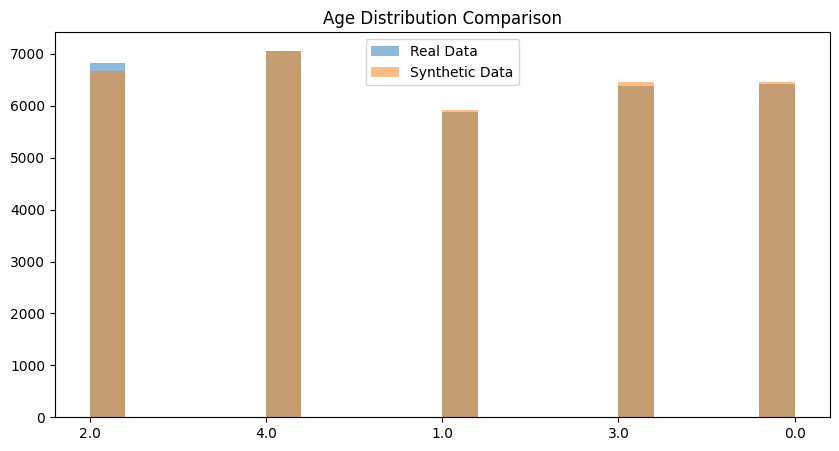

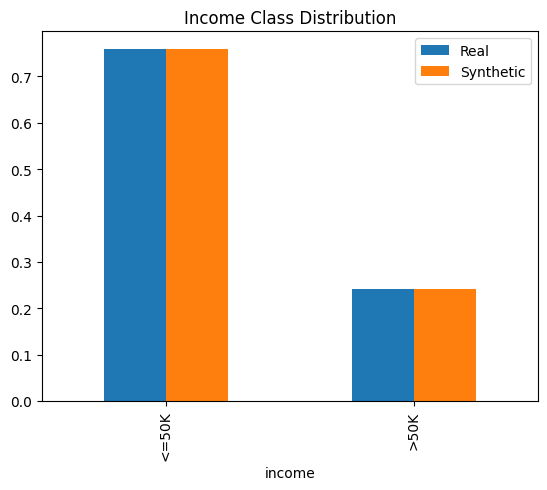

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(df["age"], alpha=0.5, label="Real Data", bins=20)
plt.hist(synthetic_df["age"], alpha=0.5, label="Synthetic Data", bins=20)
plt.title("Age Distribution Comparison")
plt.legend()
plt.show()

income_real = df["income"].value_counts(normalize=True)
income_synth = synthetic_df["income"].value_counts(normalize=True)
pd.DataFrame({"Real": income_real, "Synthetic": income_synth}).plot(kind="bar")
plt.title("Income Class Distribution")
plt.show()


To assess how well the synthetic data matches the original dataset, we compare the distributions of each categorical variable. The histograms show the frequency (normalized as density) of each category in both the original (blue) and synthetic (red) datasets. This helps evaluate how accurately the Bayesian Network has captured the underlying patterns in the data.


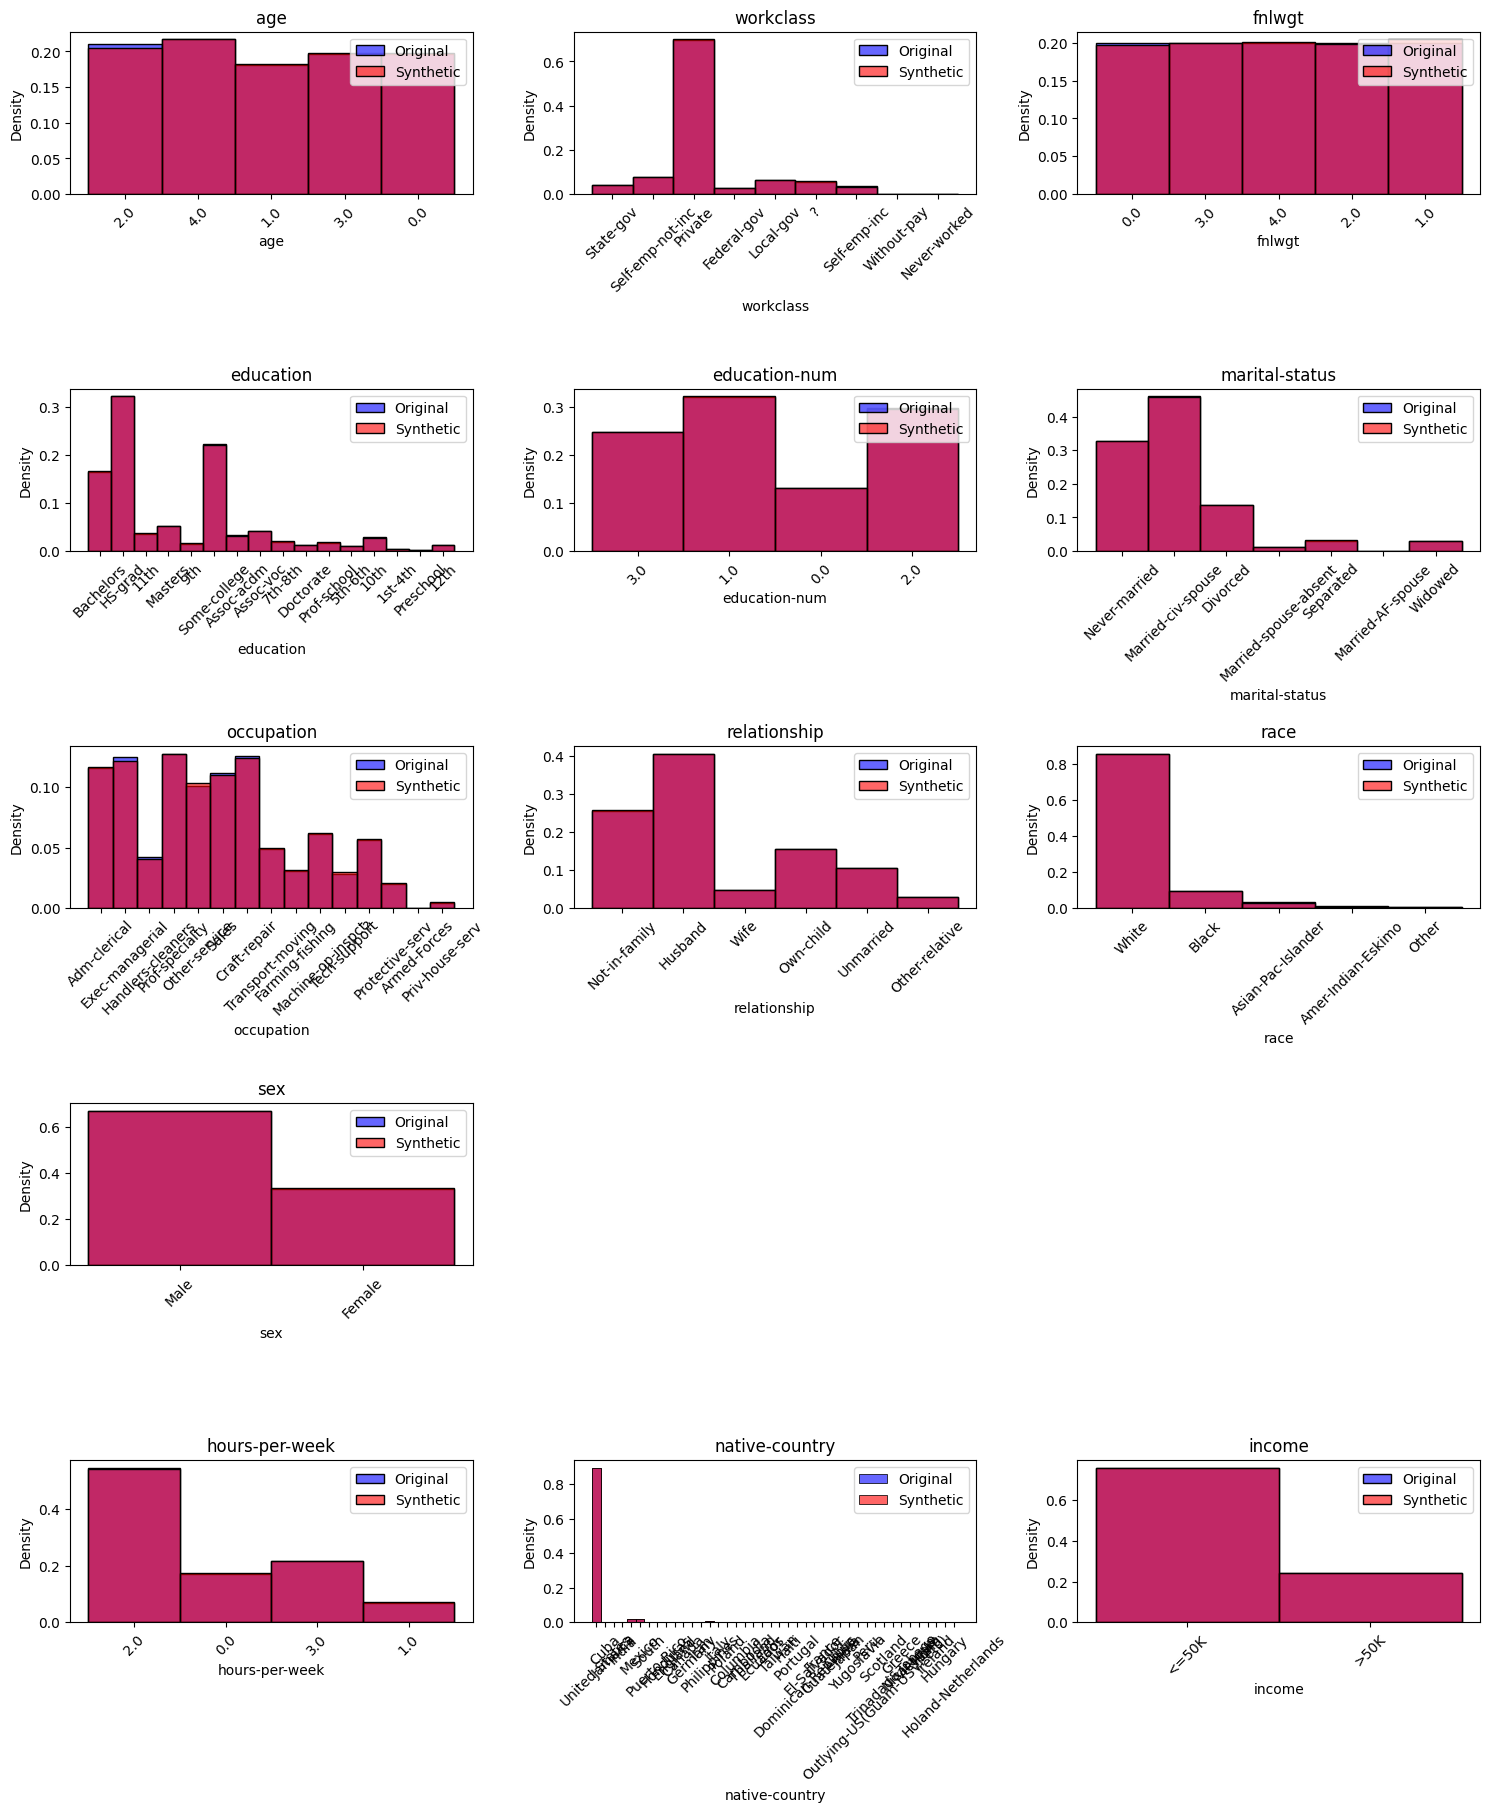

In [11]:
cat_cols = df.columns

plt.figure(figsize=(15, 20))
for i, col in enumerate(cat_cols):
    if col in synthetic_df.columns:
        plt.subplot(6, 3, i + 1)
        sns.histplot(df[col], stat="density", kde=False, bins=10, color="blue", label="Original", alpha=0.6)
        sns.histplot(synthetic_df[col], stat="density", kde=False, bins=10, color="red", label="Synthetic", alpha=0.6)
        plt.title(col)
        plt.xticks(rotation=45)
        plt.legend()
plt.tight_layout()
plt.show()


# Similarity

To evaluate the similarity between the original and synthetic datasets, we compute the Jaccard similarity score for each categorical feature. This metric measures the similarity between the label-encoded values of the original and synthetic columns, providing a numeric indicator of how well the synthetic data preserves the original categorical distributions.


In [12]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelEncoder

print("Jaccard Similarity between original and synthetic (categorical features):")
for col in cat_cols:
  if col in synthetic_df.columns:
    le = LabelEncoder()
    a = le.fit_transform(df[col])
    b = le.transform(synthetic_df[col])
    similarity = jaccard_score(a, b, average='macro')
    print(f"{col}: {similarity:.4f}")


Jaccard Similarity between original and synthetic (categorical features):
age: 0.1108
workclass: 0.0752
fnlwgt: 0.1094
education: 0.0346
education-num: 0.1432
marital-status: 0.0870
occupation: 0.0357
relationship: 0.0978
race: 0.1648
sex: 0.3537
hours-per-week: 0.1561
native-country: 0.0205
income: 0.3737


Cosine similarity is a metric used to measure the similarity between two vectors. It quantifies the angle between these vectors in a multi-dimensional space, therefore it can determine how much two data points are alike based on their features or characteristics.

Formula:

Cosine Similarity = (A · B) / (||A|| ||B||)

In case of synthetic data generation it can be used to compare the overall feature vectors of real and synthetic data points. This could help assess how similar the synthetic data is to the real data in terms of its overall characteristics.



In [13]:
common_numeric_cols = [col for col in disc_cols if col in df.columns and col in synthetic_df.columns]

real_numeric = df[common_numeric_cols].astype(float)
synthetic_numeric = synthetic_df[common_numeric_cols].astype(float)

cos_sim_matrix = cosine_similarity(real_numeric, synthetic_numeric)

max_similarities = cos_sim_matrix.max(axis=1)
mean_max_similarity = max_similarities.mean()

print(f"Mean of max cosine similarity (Real to Synthetic): {mean_max_similarity:.3f}")

Mean of max cosine similarity (Real to Synthetic): 0.996


# Distance to Closest Record (DCR)

This tells us how close each synthetic record is to its nearest real record, beacuse if synthetic data is too similar, it may leak private information.

DCR is usually computed as the Euclidean distance between each synthetic record and the closest real record. A higher value of DCR means greater distance, i.e., synthetic records are not too similar to any real record, which is good for privacy.



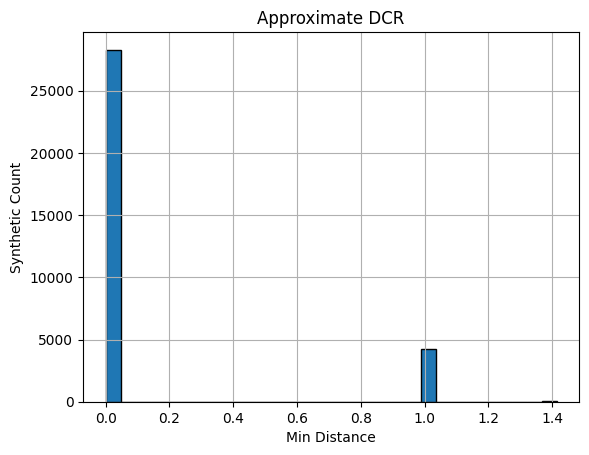

Average Approximate DCR: 0.132


In [17]:
from sklearn.metrics import pairwise_distances

# Sample a subset of real records to reduce memory usage
real_sample = df[common_numeric_cols].astype(float).sample(n=1000, random_state=42)
synthetic_numeric = synthetic_df[common_numeric_cols].astype(float)

distances = pairwise_distances(synthetic_numeric, real_sample)
min_distances = distances.min(axis=1)

plt.hist(min_distances, bins=30, edgecolor='k')
plt.title("Approximate DCR")
plt.xlabel("Min Distance")
plt.ylabel("Synthetic Count")
plt.grid(True)
plt.show()

print(f"Average Approximate DCR: {min_distances.mean():.3f}")


This code cell computes the mutual information between corresponding categorical columns.

In [27]:
from sklearn.metrics import mutual_info_score

print("Mutual Information per feature:")
for col in cat_cols:
  if col in synthetic_df.columns:
    mi = mutual_info_score(df[col], synthetic_df[col])
    print(f"{col} = {mi:.4f}")


Mutual Information per feature:
age = 0.0003
workclass = 0.0009
fnlwgt = 0.0003
education = 0.0032
education-num = 0.0002
marital-status = 0.0007
occupation = 0.0028
relationship = 0.0004
race = 0.0002
sex = 0.0000
hours-per-week = 0.0001
native-country = 0.0112
income = 0.0000


# Privacy

K-anonymity ensures that each individual in a dataset cannot be distinguished from at least k-1 other individuals with respect to the quasi-identifiers in the dataset. This is done through generalisation, suppression and sometimes top- and bottom-coding. Applying k-anonymity makes it more difficult for an attacker to re-identify specific individuals in the dataset.



In [19]:
qi_columns = ['age', 'education', 'race', 'sex']
qi_df = df[qi_columns]

# Count frequency of each quasi-identifier combination
freqs = qi_df.value_counts()
k_anonymity = freqs.min()

print(f"Estimated k-Anonymity: {k_anonymity}")


Estimated k-Anonymity: 1


This metric measures the risk associated with disclosing the synthetic data, it is a useful measurement if we want to know whether synthetic data is leaking patterns that pertain to sensitive information. For example if an attacker has prior knowledge about certain attributes (e.g. a person's age and gender) and they are given access to the full synthetic data, would they be able to make better guesses about what they don't know (e.g. that person's income)?



In [23]:
from sdmetrics.single_table import DisclosureProtection

common_cols = df.columns.intersection(synthetic_df.columns)
real_data = df[common_cols].astype(str)
synthetic_data = synthetic_df[common_cols].astype(str)

score = DisclosureProtection.compute(
    real_data=real_data,
    synthetic_data=synthetic_data,
    known_column_names=['age', 'sex'],
    sensitive_column_names=['income']
)

print(f"Disclosure Risk Score : {score:.2f}")

Disclosure Risk Score : 0.63


# Bayesian Network Structure

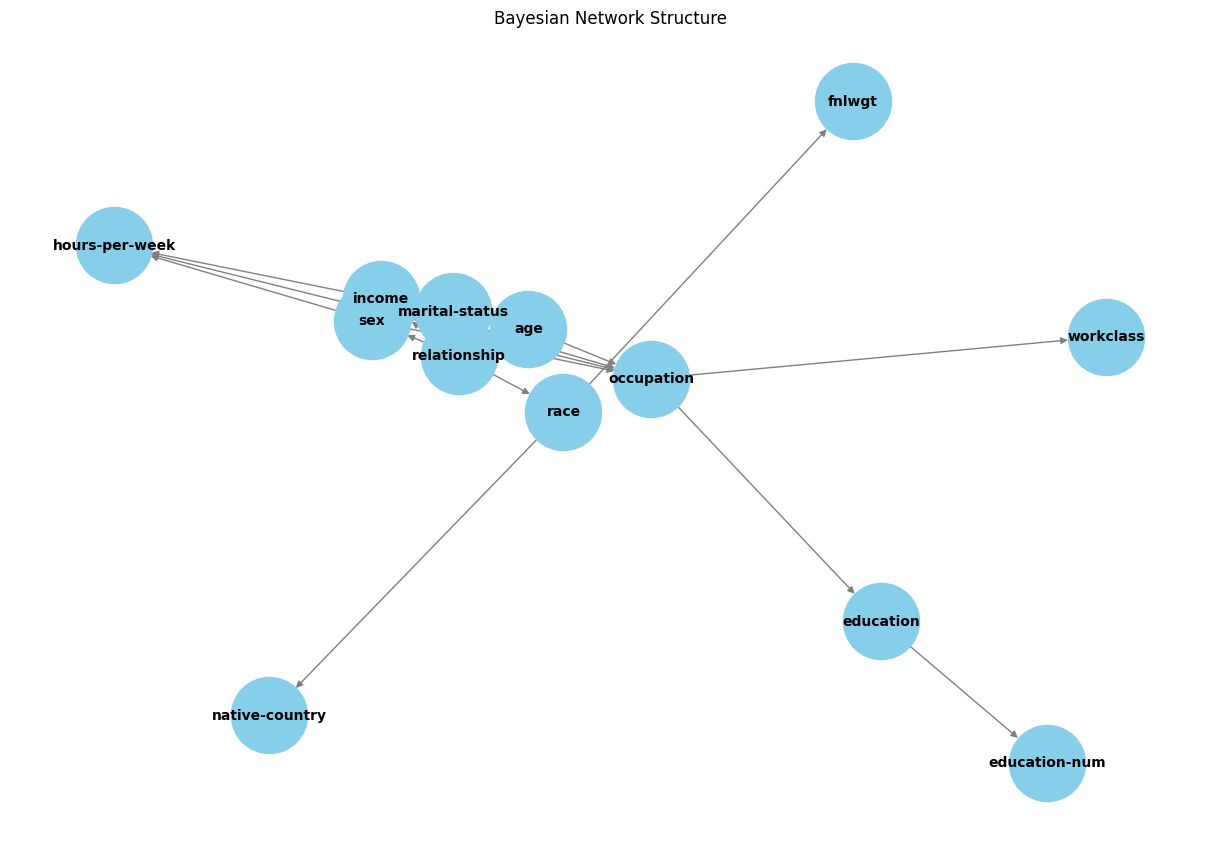

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Draw the learned network
plt.figure(figsize=(12, 8))

G = nx.DiGraph(model.edges())

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Bayesian Network Structure")
plt.show()


In [15]:
synthetic_df.to_csv("synthetic_adult_pgmpy.csv", index=False)
print("Synthetic dataset saved to 'synthetic_adult_pgmpy.csv'")


Synthetic dataset saved to 'synthetic_adult_pgmpy.csv'
